In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from pandas.io.formats.style import Styler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

import os
import sys
import datetime
from tqdm import tqdm

import wandb

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, log_loss

from pygam import LogisticGAM, s, te

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
from src.data_processing.fi import get_fi
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)

In [4]:
from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
grn = Style.BRIGHT + Fore.GREEN
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

rc = {
    "axes.facecolor": "#FFFEF8",
    "figure.facecolor": "#FFFEF8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

In [5]:
orig = pd.read_csv(os.path.join(CFG.RAW_DATA, 'Pulsar.csv'))
train = pd.read_csv(os.path.join(CFG.RAW_DATA, 'train.csv')).drop(columns='id')
test = pd.read_csv(os.path.join(CFG.RAW_DATA, 'test.csv')).drop(columns='id')

In [6]:
def log_(column):
    return np.log(-min(column) + 1 + column)

In [7]:
train[['Skewness', 'Skewness_DMSNR_Curve']] = train.apply({'Skewness': log_, 'Skewness_DMSNR_Curve': log_})
test[['Skewness', 'Skewness_DMSNR_Curve']] = test.apply({'Skewness': log_, 'Skewness_DMSNR_Curve': log_})

In [16]:
[train.columns.get_loc(c) for c in train.columns]

Index(['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve',
       'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'Class'],
      dtype='object')

In [13]:
X = train.drop('Class', axis=1).values
y = train['Class'].values

In [17]:
model = (s(0), s(1), s(2, n_splines=30), s(3), s(4), s(5), s(6), 
         s(7), te(2, 7), te(1, 6), te(3, 8))

In [23]:
gam = LogisticGAM(s(0) + s(1) + s(2, n_splines=30) + s(3) + s(4) + s(5) + s(6) + s(7) + te(2, 6) + te(1, 5) + te(3, 7)).fit(X, y)

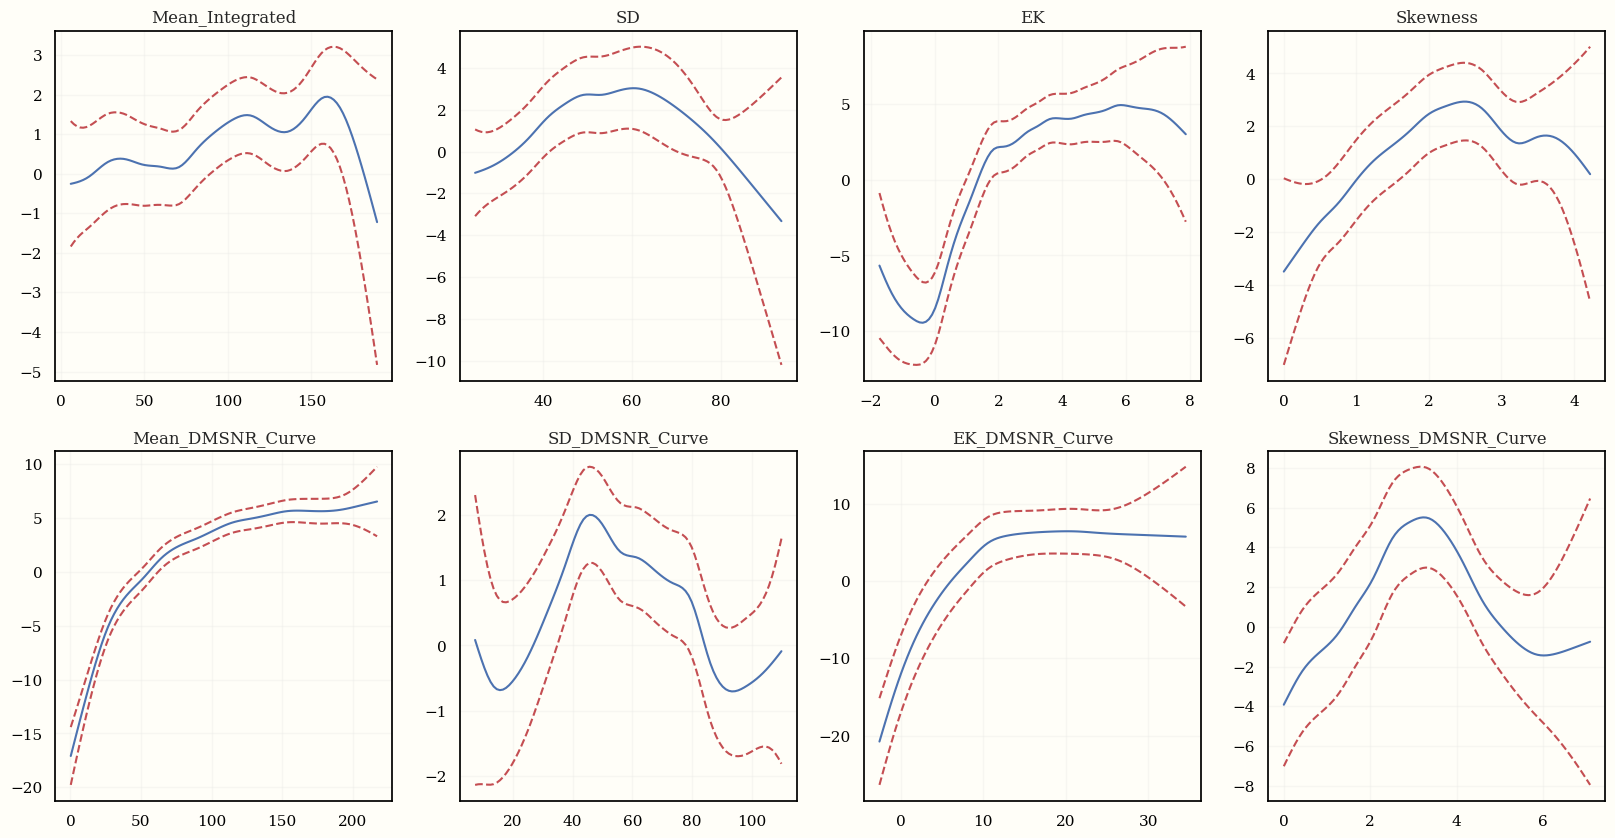

In [35]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
titles = list(test.columns)

for i, ax in enumerate(axs.ravel()):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [36]:
def plot3d(gam, idx, interactions):
    XX = gam.generate_X_grid(term=idx, meshgrid=True)
    Z = gam.partial_dependence(term=idx, X=XX, meshgrid=True)

    title_idx = idx % 8
    title = interactions[title_idx]

    fig = go.Figure(data=[go.Surface(z=Z, x=XX[0], y=XX[1])])
    fig.update_layout(title=title, autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
    fig.show()

In [37]:
interactions = [f'{test.columns[x]} + {test.columns[y]}' for x, y in [(2, 6), (1, 5), (3, 7)]]



In [38]:
plot3d(gam, 9, interactions)

In [39]:
plot3d(gam, 10, interactions)

In [42]:
plot3d(gam,8, interactions)

In [43]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     92.7866
Link Function:                        LogitLink Log Likelihood:                                 -3514.7273
Number of Samples:                       117564 AIC:                                             7215.0276
                                                AICc:                                             7215.179
                                                UBRE:                                                2.062
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.9036
Feature Function                  Lam